In [17]:
import sys
from pathlib import Path
sys.path.insert(0, str(Path().resolve().parent))
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

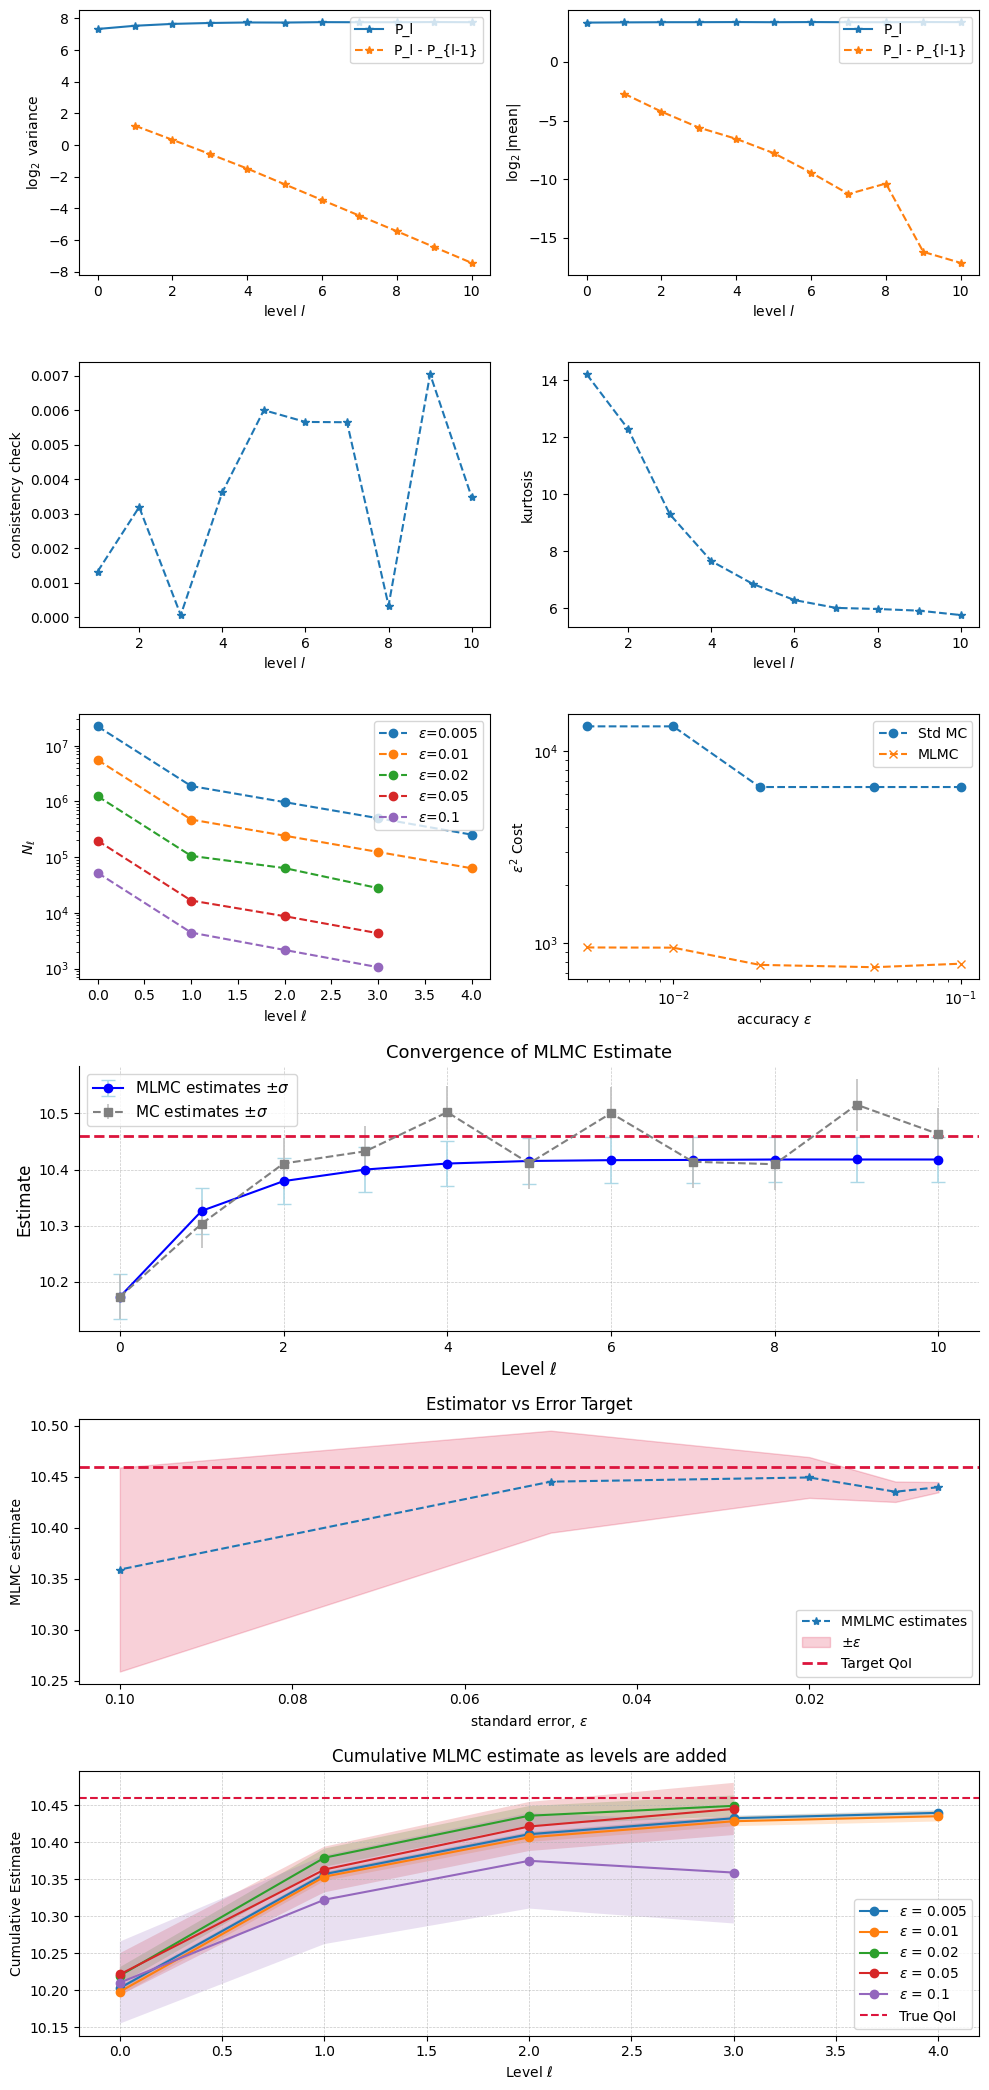

In [ ]:
def cpp_outputs_plotting(complexity_path, convergence_path, validation_value=None):
    # Load data
    df_comp = pd.read_csv(complexity_path)
    df_conv = pd.read_csv(convergence_path)

    # Extract columns for convergence plots
    L = df_conv['level'].values
    del1 = df_conv['ave_Pf-Pc'].values
    del2 = df_conv['ave_Pf'].values
    var1 = df_conv['var_Pf-Pc'].values
    var2 = df_conv['var_Pf'].values
    kur1 = df_conv['kurtosis'].values
    chk1 = df_conv['check'].values
    cost = df_conv['cost'].values
    N = df_conv['N'].iloc[0]

    # Extract columns for complexity plots
    Eps = df_comp['eps'].values
    mlmc_estimate = df_comp['mlmc_estimate'].values
    mlmc_cost = df_comp['mlmc_cost'].values
    std_mc_cost = df_comp['std_mc_cost'].values
    Nl_cols = [c for c in df_comp.columns if c.startswith("Nl_")]
    Yls_cols = [c for c in df_comp.columns if c.startswith("Yl_")]
    Vls_cols = [c for c in df_comp.columns if c.startswith("Vl_")]
    Nls = df_comp[Nl_cols].values.astype(float).T  # shape (n_levels, n_eps)
    Yls = df_comp[Yls_cols].values.astype(float).T
    Vls = df_comp[Vls_cols].values.astype(float).T


    # -- Start plotting --
    nrows = 6
    fig = plt.figure(figsize=(10, 3.5 * nrows))
    gs = gridspec.GridSpec(nrows, 2, figure=fig)

    axs = []
    for row in range(0, 3):
        axs.append(fig.add_subplot(gs[row, 0]))
        axs.append(fig.add_subplot(gs[row, 1]))
    
    var_ax, mean_ax, chk_ax, kur_ax, count_ax, cost_ax = axs
    validation_ax = fig.add_subplot(gs[3, :])
    conv_ax = fig.add_subplot(gs[4, :])
    results_convergence_ax = fig.add_subplot(gs[5, :])

    var_ax.plot(L, np.log2(var2), '-*', label='P_l')
    var_ax.plot(L[1:], np.log2(var1[1:]), '--*', label='P_l - P_{l-1}')
    var_ax.set_xlabel(r'level $l$')
    var_ax.set_ylabel(r'$\log_2$ variance')
    var_ax.legend(loc='upper right')

    mean_ax.plot(L, np.log2(np.abs(del2)), '-*', label='P_l')
    mean_ax.plot(L[1:], np.log2(np.abs(del1[1:])), '--*', label='P_l - P_{l-1}')
    mean_ax.set_xlabel(r'level $l$')
    mean_ax.set_ylabel(r'$\log_2 |\text{mean}|$')
    mean_ax.legend(loc='upper right')

    chk_ax.plot(L[1:] - 1e-9, chk1[1:], '--*')
    chk_ax.set_xlabel(r'level $l$')
    chk_ax.set_ylabel('consistency check')

    kur_ax.plot(L[1:] - 1e-9, kur1[1:], '--*')
    kur_ax.set_xlabel(r'level $l$')
    kur_ax.set_ylabel('kurtosis')

    for i, eps in enumerate(Eps):
        ls = np.arange(Nls[:,i].size)
        count_ax.semilogy(ls, Nls[:,i], '--o', label=fr'$\epsilon$={eps:.3g}')
    count_ax.set_xlabel(r'level $\ell$')
    count_ax.set_ylabel('$N_\\ell$')
    count_ax.legend()

    cost_ax.loglog(Eps, Eps**2 * std_mc_cost, '--o', label='Std MC')
    cost_ax.loglog(Eps, Eps**2 * mlmc_cost, '--x', label='MLMC')
    cost_ax.set_xlabel(r'accuracy $\epsilon$')
    cost_ax.set_ylabel(r'$\epsilon^2$ Cost')
    cost_ax.legend()


    # MLMC estimates
    mlmc_estimator = np.cumsum(del1)
    mlmc_se = np.sqrt(np.cumsum(var1) / N)
    validation_ax.errorbar(L, mlmc_estimator, yerr=mlmc_se, fmt='o-', capsize=5, elinewidth=1.2, color='blue', ecolor='lightblue',
                            label=r'MLMC estimates $\pm \sigma$ ')
    # Plot E[P_l] for context
    mc_se = np.sqrt(var2 / N)
    validation_ax.errorbar(L, del2, yerr=mc_se, fmt='s--', elinewidth=1.2, color='gray', ecolor='silver', label=r'MC estimates $\pm \sigma$')
    validation_ax.set_xlabel(r'Level $\ell$', fontsize=12)
    validation_ax.set_ylabel(r'Estimate', fontsize=12)
    validation_ax.tick_params(axis='both', which='major', labelsize=10)
    validation_ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    validation_ax.spines['top'].set_visible(False)
    validation_ax.spines['right'].set_visible(False)
    validation_ax.set_title('Convergence of MLMC Estimate', fontsize=13)
    validation_ax.legend(loc='best', frameon=True, fontsize=11)
    if validation_value is not None:
        validation_ax.axhline(y=validation_value, linestyle='--', color='crimson', linewidth=2, label='Target QoI')

    conv_ax.plot(Eps, mlmc_estimate, '--*', label='MMLMC estimates')
    conv_ax.fill_between(
        Eps, mlmc_estimate - Eps, mlmc_estimate + Eps, color='crimson', alpha=0.2, label=r'$\pm \epsilon$'
    )
    if validation_value is not None:
        conv_ax.axhline(y=validation_value, linestyle='--', color='crimson', linewidth=2, label='Target QoI')
    conv_ax.set_xlabel(r'standard error, $\epsilon$')
    conv_ax.set_ylabel(r'MLMC estimate')
    conv_ax.invert_xaxis()
    conv_ax.legend()
    conv_ax.set_title("Estimator vs Error Target")

    for i, eps in enumerate(Eps):
        Nl = Nls[:,i]
        Yl = Yls[:,i]
        Vl = Vls[:,i]
        # Standard error per level
        se_array = np.sqrt(np.cumsum(Vl / Nl))
        # Cumulative sum of estimator
        cumulative_est = np.cumsum(Yl)
        results_convergence_ax.plot(np.arange(len(cumulative_est)), cumulative_est, '-o', label=fr'$\epsilon$ = {eps:.3g}')
        results_convergence_ax.fill_between(np.arange(len(cumulative_est)),
                                            cumulative_est - se_array,
                                            cumulative_est + se_array,
                                            alpha=0.2, linewidth=0)
    if validation_value is not None:
        results_convergence_ax.axhline(y=validation_value, linestyle='--', color='crimson', label='True QoI')
        results_convergence_ax.set_xlabel(r'Level $\ell$')
        results_convergence_ax.set_ylabel(r'Cumulative Estimate')
        results_convergence_ax.set_title('Cumulative MLMC estimate as levels are added')
        results_convergence_ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
        results_convergence_ax.legend()
    else:
        results_convergence_ax.text(0.2, 0.5, "Per-level MLMC estimators not found in CSV.", fontsize=13)

    plt.tight_layout()
    plt.show()


cpp_outputs_plotting(complexity_path='../mlmc_cpp/outputs/mlmc_complexity_gbm_euler.csv',
                    convergence_path='../mlmc_cpp/outputs/mlmc_convergence_gbm_euler.csv',
                    validation_value=10.46) 






In [31]:
df = pd.read_csv('../mlmc_cpp/outputs/mlmc_complexity_gbm_euler.csv')
df

,eps,mlmc_estimate,mlmc_cost,std_mc_cost,Nl_0,Nl_1,Nl_2,Nl_3,Nl_4,Nl_5,Nl_6
0,0.005,10.4482,56694600.0,2.188030e+09,27177368,2326203,1199697,617189,313794.0,157243.0,79313.0
1,0.010,10.4473,11708200.0,2.713500e+08,6168185,528573,271533,139050,70670.0,36052.0,NaN
2,0.020,10.4629,2936060.0,6.783750e+07,1544021,132131,68006,35503,17757.0,8988.0,NaN
3,0.050,10.4651,387349.0,5.340860e+06,224383,19387,9902,5149,2712.0,NaN,NaN
4,0.100,10.5094,77443.0,6.460720e+05,50055,4330,2264,1209,NaN,NaN,NaN


<>:11: SyntaxWarning: invalid escape sequence '\l'
<>:11: SyntaxWarning: invalid escape sequence '\l'
/var/folders/l5/rhh7z5c528b5hjwqy30m3vzr0000gn/T/ipykernel_6637/1410958981.py:11: SyntaxWarning: invalid escape sequence '\l'
  axs[0,0].set_ylabel('$\log_2$ variance')


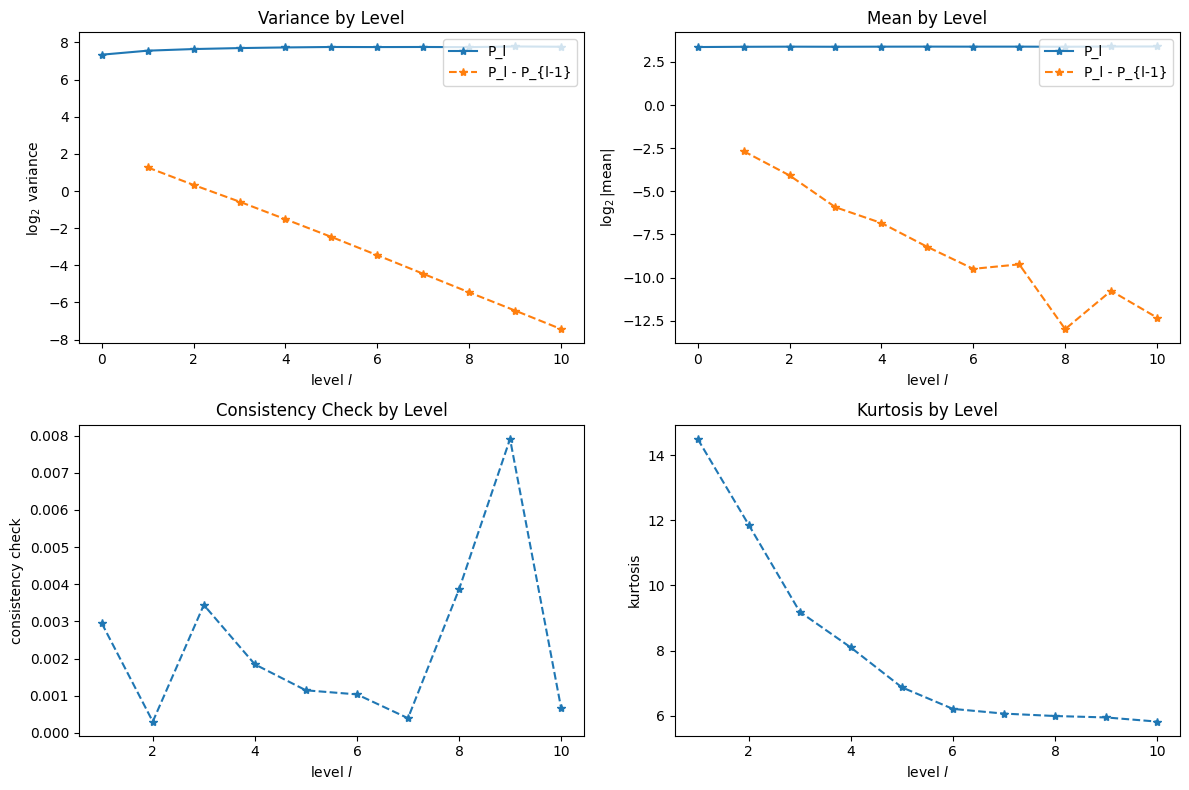

In [15]:
levels = df['level'].values
var_Pf = df['var_Pf'].values
var_PfPc = df['var_Pf-Pc'].values

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# 1. Variance plot
axs[0,0].plot(levels, np.log2(var_Pf), '-*', label='P_l')
axs[0,0].plot(levels[1:], np.log2(var_PfPc[1:]), '--*', label='P_l - P_{l-1}')
axs[0,0].set_xlabel('level $l$')
axs[0,0].set_ylabel('$\log_2$ variance')
axs[0,0].legend(loc='upper right')
axs[0,0].set_title('Variance by Level')

# 2. Mean plot
axs[0,1].plot(levels, np.log2(np.abs(df['ave_Pf'])), '-*', label='P_l')
axs[0,1].plot(levels[1:], np.log2(np.abs(df['ave_Pf-Pc'][1:])), '--*', label='P_l - P_{l-1}')
axs[0,1].set_xlabel('level $l$')
axs[0,1].set_ylabel(r'$\log_2 |\text{mean}|$')
axs[0,1].legend(loc='upper right')
axs[0,1].set_title('Mean by Level')

# 3. Consistency check
axs[1,0].plot(levels[1:], df['check'][1:], '--*')
axs[1,0].set_xlabel('level $l$')
axs[1,0].set_ylabel('consistency check')
axs[1,0].set_title('Consistency Check by Level')

# 4. Kurtosis
axs[1,1].plot(levels[1:], df['kurtosis'][1:], '--*')
axs[1,1].set_xlabel('level $l$')
axs[1,1].set_ylabel('kurtosis')
axs[1,1].set_title('Kurtosis by Level')

plt.tight_layout()
plt.show()


<>:39: SyntaxWarning: invalid escape sequence '\e'
<>:39: SyntaxWarning: invalid escape sequence '\e'
/var/folders/l5/rhh7z5c528b5hjwqy30m3vzr0000gn/T/ipykernel_6637/1250198410.py:39: SyntaxWarning: invalid escape sequence '\e'
  axs[1,0].set_xlabel('level $\ell$')


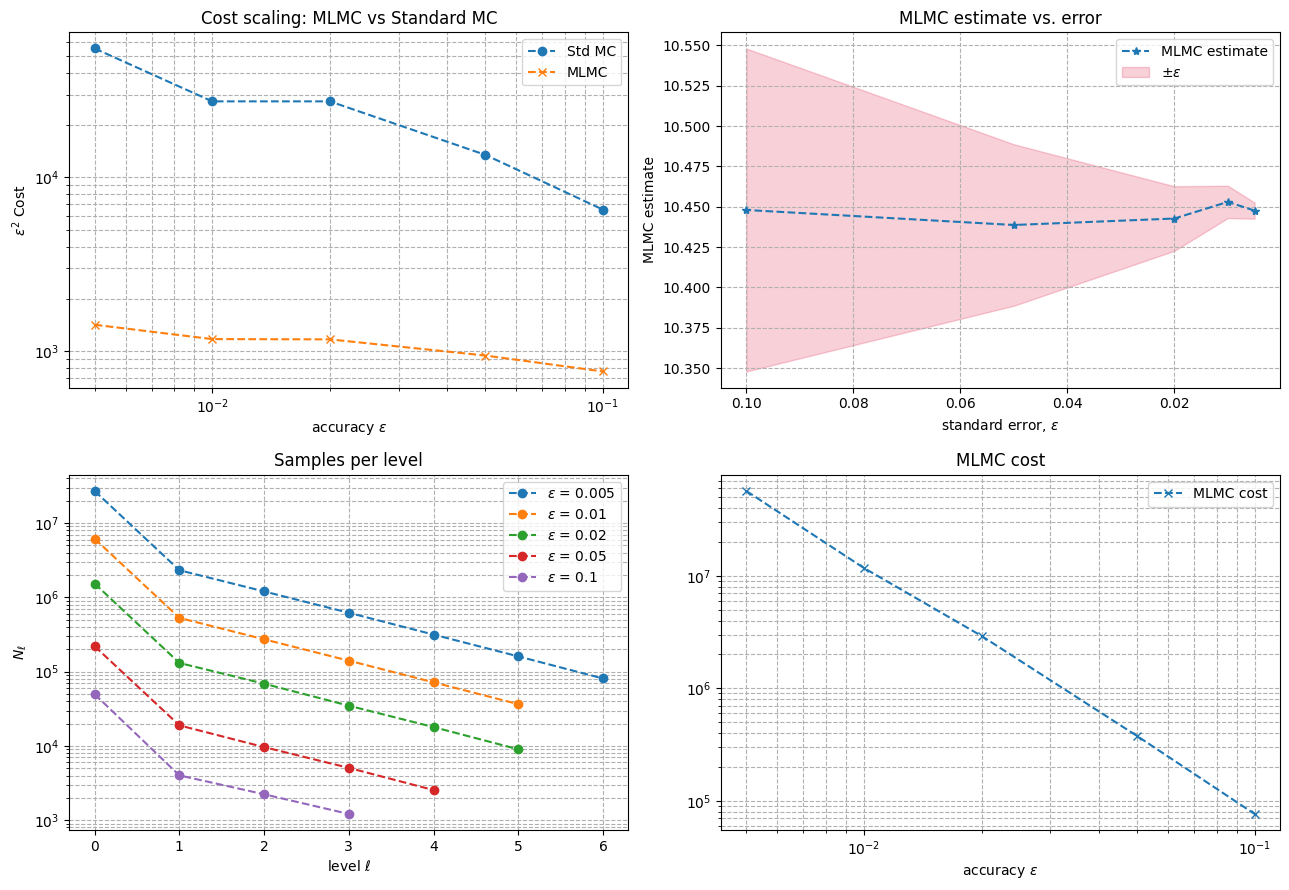

In [16]:
# Read your MLMC complexity CSV
csv_path = '../mlmc_cpp/outputs/mlmc_complexity_gbm_euler.csv'  # adjust path if needed
df = pd.read_csv(csv_path)

# Extract values
eps = df['eps'].values
mlmc_estimate = df['mlmc_estimate'].values
mlmc_cost = df['mlmc_cost'].values
std_mc_cost = df['std_mc_cost'].values
nl_cols = [col for col in df.columns if col.startswith('Nl_')]
Nl = df[nl_cols].values.T  # shape: (n_levels, n_eps)

# Set up 2x2 subplots
fig, axs = plt.subplots(2, 2, figsize=(13, 9))

# Plot 1: Cost scaling
axs[0,0].loglog(eps, eps**2 * std_mc_cost, '--o', label='Std MC')
axs[0,0].loglog(eps, eps**2 * mlmc_cost, '--x', label='MLMC')
axs[0,0].set_xlabel(r'accuracy $\epsilon$')
axs[0,0].set_ylabel(r'$\epsilon^2$ Cost')
axs[0,0].set_title('Cost scaling: MLMC vs Standard MC')
axs[0,0].legend()
axs[0,0].grid(True, which="both", ls="--")

# Plot 2: MLMC solution vs. error
axs[0,1].plot(eps, mlmc_estimate, '--*', label='MLMC estimate')
axs[0,1].fill_between(eps, mlmc_estimate-eps, mlmc_estimate+eps, color='crimson', alpha=0.2, label=r'$\pm\epsilon$')
axs[0,1].set_xlabel(r'standard error, $\epsilon$')
axs[0,1].set_ylabel('MLMC estimate')
axs[0,1].set_title('MLMC estimate vs. error')
axs[0,1].invert_xaxis()
axs[0,1].legend()
axs[0,1].grid(True, ls='--')

# Plot 3: Samples per level
levels = np.arange(Nl.shape[0])
for i in range(Nl.shape[1]):
    axs[1,0].semilogy(levels, Nl[:,i], '--o', label=fr'$\epsilon$ = {eps[i]:.3g}')
axs[1,0].set_xlabel('level $\ell$')
axs[1,0].set_ylabel('$N_\\ell$')
axs[1,0].set_title('Samples per level')
axs[1,0].legend()
axs[1,0].grid(True, which="both", ls="--")

# Plot 4: Absolute error vs eps (if you want to show how error decays)
if 'validation_value' in df.columns:
    validation_value = df['validation_value'].values[0]
    abs_error = np.abs(mlmc_estimate - validation_value)
    axs[1,1].loglog(eps, abs_error, '--o', color='purple', label='|Estimate - True|')
    axs[1,1].set_ylabel('Absolute error')
    axs[1,1].set_title('Abs error vs error tol')
    axs[1,1].legend()
else:
    # Just repeat cost plot for illustration if no validation value
    axs[1,1].loglog(eps, mlmc_cost, '--x', label='MLMC cost')
    axs[1,1].set_title('MLMC cost')
    axs[1,1].legend()
axs[1,1].set_xlabel(r'accuracy $\epsilon$')
axs[1,1].grid(True, which="both", ls="--")

plt.tight_layout()
plt.show()


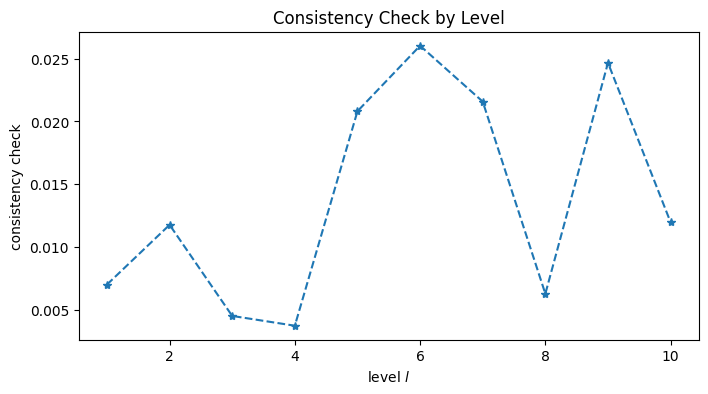

In [7]:
plt.figure(figsize=(8,4))
plt.plot(levels[1:], df['check'][1:], '--*')
plt.xlabel('level $l$')
plt.ylabel('consistency check')
plt.title('Consistency Check by Level')
plt.show()

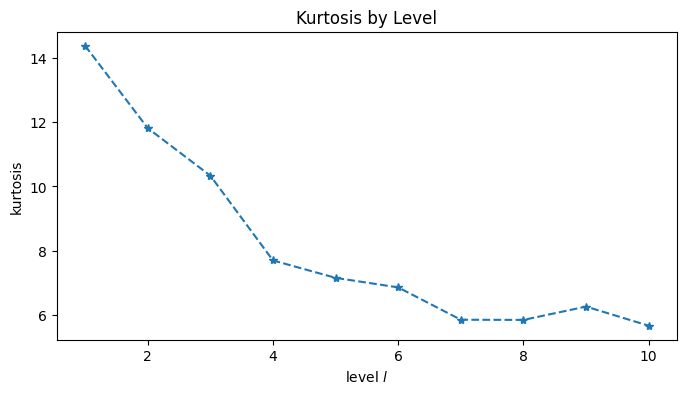

In [8]:
plt.figure(figsize=(8,4))
plt.plot(levels[1:], df['kurtosis'][1:], '--*')
plt.xlabel('level $l$')
plt.ylabel('kurtosis')
plt.title('Kurtosis by Level')
plt.show()